### The Libraries

In [144]:
from pickle import load,dump,HIGHEST_PROTOCOL
from numpy import savetxt
from numpy.random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.optimizers.schedules import LearningRateSchedule
from keras.metrics import Mean
from tensorflow import data,train,convert_to_tensor, int64, math, cast,float32, linalg, ones,maximum, newaxis, reduce_sum,equal,argmax,GradientTape,TensorSpec,function,int64,Module,TensorArray
from keras.losses import sparse_categorical_crossentropy
from keras import Model
from keras.layers import Dense, Input
from time import time

#### Playing around with the dataset

This dataset is filled with translations of English to German. So it is essentially a neural machine translation dataset  

In [200]:
clean_dataset = load(open('english-german-both.pkl','rb'))

In [201]:
clean_dataset

array([['i like both', 'ich mag beide'],
       ['she misses him', 'er fehlt ihr'],
       ['i followed him', 'ich folgte ihm'],
       ...,
       ['tom is cooking', 'tom kocht'],
       ['youre upset', 'sie sind besturzt'],
       ['do you see me', 'sehen sie mich']], dtype='<U370')

In [202]:
sample_dataset = clean_dataset[:6000,:]

In [203]:
sample_dataset

array([['i like both', 'ich mag beide'],
       ['she misses him', 'er fehlt ihr'],
       ['i followed him', 'ich folgte ihm'],
       ...,
       ['open your mouth', 'offnen sie den mund'],
       ['love is blind', 'liebe ist blind'],
       ['go home quickly', 'geh schnell nach hause']], dtype='<U370')

In [245]:
sample_dataset[:,0]

array(['<START> tom did do it <EOS>', '<START> it might rain <EOS>',
       '<START> i was rude <EOS>', ..., '<START> im a teacher <EOS>',
       '<START> turn it off <EOS>', '<START> i want that <EOS>'],
      dtype='<U370')

Need to append start and end tokens for each of the sentences

In [204]:
for i in range(sample_dataset[:,0].size):
    sample_dataset[i, 0] = "<START> " + sample_dataset[i, 0] + " <EOS>"
    sample_dataset[i, 1] = "<START> " + sample_dataset[i, 1] + " <EOS>"

In [205]:
sample_dataset

array([['<START> i like both <EOS>', '<START> ich mag beide <EOS>'],
       ['<START> she misses him <EOS>', '<START> er fehlt ihr <EOS>'],
       ['<START> i followed him <EOS>', '<START> ich folgte ihm <EOS>'],
       ...,
       ['<START> open your mouth <EOS>',
        '<START> offnen sie den mund <EOS>'],
       ['<START> love is blind <EOS>', '<START> liebe ist blind <EOS>'],
       ['<START> go home quickly <EOS>',
        '<START> geh schnell nach hause <EOS>']], dtype='<U370')

In [206]:
shuffle(sample_dataset)

In [207]:
sample_dataset

array([['<START> tom did do it <EOS>',
        '<START> doch tom hat es gemacht <EOS>'],
       ['<START> it might rain <EOS>', '<START> es konnte regnen <EOS>'],
       ['<START> i was rude <EOS>', '<START> ich war ruppig <EOS>'],
       ...,
       ['<START> im a teacher <EOS>', '<START> ich bin lehrerin <EOS>'],
       ['<START> turn it off <EOS>', '<START> mach ihn aus <EOS>'],
       ['<START> i want that <EOS>', '<START> ich will das <EOS>']],
      dtype='<U370')

### The task starts !!! 

#### Prepare Dataset Class

Creating the prepare dataset class which preprocesses and splits our dataset

In [218]:
class PrepareDataset:
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.n_sentences = 10000 # Number of sentences to include in the dataset
        self.train_split = 0.8  # Ratio of the training data split
        self.val_split = 0.1 # Ratio of the validation data split
    
    # Fit a tokenizer
    def create_tokenizer(self, dataset):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(dataset)
        return tokenizer
    
    def find_seq_length(self, dataset):
        return max(len(seq.split()) for seq in dataset)
    
    def find_vocab_size(self, tokenizer, dataset):
        tokenizer.fit_on_texts(dataset)
        return len(tokenizer.word_index) + 1

    # Encode and pad the input sequences
    def encode_pad(self, dataset, tokenizer, seq_length):
        x = tokenizer.texts_to_sequences(dataset)
        x = pad_sequences(x, maxlen=seq_length, padding='post')
        x = convert_to_tensor(x, dtype=int64)
        return x
    
    def save_tokenizer(self, tokenizer, name):
        with open(name + '_tokenizer.pkl', 'wb') as handle:
            dump(tokenizer, handle, protocol=HIGHEST_PROTOCOL)
    
    def __call__(self, filename, **kwargs):
        # Load a clean dataset
        clean_dataset = load(open(filename, 'rb'))
        
        # Reduce dataset size
        dataset = clean_dataset[:self.n_sentences,:]
        
        # Including the start and end tokens
        for i in range(dataset[:,0].size):
            dataset[i, 0] = "<START> " + dataset[i, 0] + " <EOS>"
            dataset[i, 1] = "<START> " + dataset[i, 1] + " <EOS>"
        
        # Random shuffle
        shuffle(dataset)
        
        # Split the dataset
        train = dataset[:int(self.n_sentences * self.train_split)]
        val = dataset[int(self.n_sentences * self.train_split):int(self.n_sentences * (1-self.val_split))]
        test = dataset[int(self.n_sentences * (1 - self.val_split)):]
        
        # Prepare tokenizer for the encoder input
        enc_tokenizer = self.create_tokenizer(dataset[:,0])
        enc_seq_length = self.find_seq_length(dataset[:,0])
        enc_vocab_size = self.find_vocab_size(enc_tokenizer, train[:, 0])
        
         # Prepare tokenizer for the decoder input
        dec_tokenizer = self.create_tokenizer(dataset[:, 1])
        dec_seq_length = self.find_seq_length(dataset[:, 1])
        dec_vocab_size = self.find_vocab_size(dec_tokenizer, train[:, 1])
        
        # Encode and pad the input sequences
        trainX = self.encode_pad(train[:, 0], enc_tokenizer, enc_seq_length)
        trainY = self.encode_pad(train[:, 1], dec_tokenizer, dec_seq_length)
        
        
        # Encode and pad the validation input
        valX = self.encode_pad(val[:, 0], enc_tokenizer, enc_seq_length)
        valY = self.encode_pad(val[:, 1], dec_tokenizer, dec_seq_length)
        
        
        # Save the encoder tokenizer
        self.save_tokenizer(enc_tokenizer, 'enc')
        # Save the decoder tokenizer
        self.save_tokenizer(dec_tokenizer, 'dec')
        # Save the testing dataset into a text file
        savetxt('test_dataset.txt', test, fmt='%s')
    
        return (trainX, trainY,valX,valY, train,val, enc_seq_length, dec_seq_length,enc_vocab_size, dec_vocab_size)

In [219]:
dataset = PrepareDataset()

In [220]:
trainX, trainY, ValX,ValY,train_orig,Val_orig, enc_seq_length, dec_seq_length,enc_vocab_size, dec_vocab_size = dataset('english-german-both.pkl')
print(train_orig[0, 0], '\n', trainX[0, :])

<START> she needs it <EOS> 
 tf.Tensor([  1  26 273   6   2   0   0], shape=(7,), dtype=int64)


In [221]:
enc_vocab_size

2404

In [222]:
dec_vocab_size

3864

In [223]:
enc_seq_length

7

In [224]:
dec_seq_length

12

In [105]:
train_orig

array([['<START> good for you <EOS>', '<START> schon fur sie <EOS>'],
       ['<START> toms thirsty <EOS>', '<START> tom hat durst <EOS>'],
       ['<START> tom will cook <EOS>', '<START> tom wird kochen <EOS>'],
       ...,
       ['<START> cut the engine <EOS>',
        '<START> mach den motor aus <EOS>'],
       ['<START> toms great <EOS>', '<START> tom ist toll <EOS>'],
       ['<START> im very cold <EOS>', '<START> mir ist sehr kalt <EOS>']],
      dtype='<U370')

In [106]:
trainX

<tf.Tensor: shape=(8000, 7), dtype=int64, numpy=
array([[  1, 143,  78, ...,   2,   0,   0],
       [  1,  45, 347, ...,   0,   0,   0],
       [  1,   4,  65, ...,   2,   0,   0],
       ...,
       [  1, 239,  12, ...,   2,   0,   0],
       [  1,  45, 319, ...,   0,   0,   0],
       [  1,  10,  86, ...,   2,   0,   0]])>

In [107]:
print('Encoder sequence length:', enc_seq_length)

Encoder sequence length: 7


In [108]:
print(train_orig[0, 1], '\n', trainY[0, :])

<START> schon fur sie <EOS> 
 tf.Tensor([ 1 85 78  6  2  0  0  0  0  0], shape=(10,), dtype=int64)


In [109]:
print('Decoder sequence length:', dec_seq_length)

Decoder sequence length: 10


We must apply a padding value to make sure that the zero values we have appended are not processed incorrectly

In [110]:
def padding_mask(input):
    # Create mask which marks the zero padding values in the input by a 1
    mask = math.equal(input, 0)
    mask = cast(mask, float32)
    return mask

Upon receiving an input, this function will generate a tensor that marks by a value of one
wherever the input contains a value of zero.

In [111]:
from numpy import array
input = array([1, 2, 3, 4, 0, 0, 0])
print(padding_mask(input))

tf.Tensor([0. 0. 0. 0. 1. 1. 1.], shape=(7,), dtype=float32)


A look-ahead mask is required to prevent the decoder from attending to succeeding words,
such that the prediction for a particular word can only depend on known outputs for the
words that come before it.

In [112]:
def lookahead_mask(shape):
    # Mask out future entries by marking them with a 1.0
    mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)
    return mask

In [113]:
print(lookahead_mask(5))

tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


Joining the transformer encoder and decoder module

In [114]:
import tensorflow as tf
import random
import numpy as np
from keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout,TextVectorization, Embedding
from keras.backend import softmax 
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32

### General Modules - Positional embedding, attention, Feed forward layer, Normalization

In [115]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, seq_length, vocab_size, output_dim, **kwargs):
        super().__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)
        pos_embedding_matrix = self.get_position_encoding(seq_length, output_dim)
        self.word_embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dim,weights=[word_embedding_matrix],trainable=False)
        self.position_embedding_layer = Embedding(input_dim=seq_length, output_dim=output_dim,weights=[pos_embedding_matrix],trainable=False)
    
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
    
    
    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [116]:
class DotProductAttention(Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    
    def call(self,queries,keys,values,d_k,mask = None):
        
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))
        
        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask
        
        # Computing the weights by a softmax operation
        weights = softmax(scores)
        
        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)
        
    

In [117]:
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super().__init__(**kwargs)
        self.attention = DotProductAttention() # Scaled dot product attention
        self.heads = h # Number of attention heads to use
        self.d_k = d_k # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v # Dimensionality of the linearly projected values
        self.d_model = d_model # Dimensionality of the model
        self.W_q = Dense(d_k) # Learned projection matrix for the queries
        self.W_k = Dense(d_k) # Learned projection matrix for the keys
        self.W_v = Dense(d_v) # Learned projection matrix for the values
        self.W_o = Dense(d_model) # Learned projection matrix for the multi-head output
    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing:
            # (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations:
            # (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x
    
    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
        # Compute the multi-head attention output using the reshaped queries,
        # keys, and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)
        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)
        # Apply one final linear projection to the output to generate the multi-head
        # attention. Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

In [118]:
# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.layer_norm = LayerNormalization() # Layer normalization layer
    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x
        # Apply layer normalization to the sum
        return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super().__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff) # First fully connected layer
        self.fully_connected2 = Dense(d_model) # Second fully connected layer
        self.activation = ReLU() # ReLU activation layer
        
    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)
        return self.fully_connected2(self.activation(x_fc1))

### Encoder Modules

In [119]:
# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self,sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super().__init__(**kwargs)
        self.build(input_shape=[None, sequence_length, d_model])
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()
        
    
    def build_graph(self):
        input_layer = Input(shape=(self.sequence_length, self.d_model))
        return Model(inputs=[input_layer], outputs=self.call(input_layer, None, True))
    
    
    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)
        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)
        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)
    

In [120]:
# Implementing the Encoder
class Encoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate,
    **kwargs):
        super().__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size,
        d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(sequence_length,h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
    
  
    def call(self, input_sentence, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)
        return x

### Decoder Modules

In [121]:
class DecoderLayer(Layer):
    def __init__(self,sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super().__init__(**kwargs)
        self.build(input_shape=[None, sequence_length, d_model])
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.multihead_attention2 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout3 = Dropout(rate)
        self.add_norm3 = AddNormalization()
        
    
    def build_graph(self):
        input_layer = Input(shape=(self.sequence_length, self.d_model))
        return Model(inputs=[input_layer],outputs=self.call(input_layer, input_layer, None, None, True))
    
    
    def call(self, x, encoder_output, lookahead_mask, padding_mask, training):
        # Multi-head attention layer
        multihead_output1 = self.multihead_attention1(x, x, x, lookahead_mask)
         
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Add in a dropout layer
        multihead_output1 = self.dropout1(multihead_output1, training=training)
        # Followed by an Add & Norm layer
        addnorm_output1 = self.add_norm1(x, multihead_output1)
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Followed by another multi-head attention layer
        multihead_output2 = self.multihead_attention2(addnorm_output1, encoder_output,encoder_output, padding_mask)
         
        # Add in another dropout layer
        multihead_output2 = self.dropout2(multihead_output2, training=training)
        
        # Followed by another Add & Norm layer
        addnorm_output2 = self.add_norm1(addnorm_output1, multihead_output2)
        
        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output2)
        # Expected output shape = (batch_size, sequence_length, d_model)
        
        # Add in another dropout layer
        feedforward_output = self.dropout3(feedforward_output, training=training)
        
        # Followed by another Add & Norm layer
        return self.add_norm3(addnorm_output2, feedforward_output)

In [122]:
class Decoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate,**kwargs):
        super().__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size,d_model)
        self.dropout = Dropout(rate)
        self.decoder_layer = [DecoderLayer(sequence_length,h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
        
    
    def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(output_target)
        # Expected output shape = (number of sentences, sequence_length, d_model)
        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.decoder_layer):
            x = layer(x, encoder_output, lookahead_mask, padding_mask, training)
        return x

### Creating the transformer by joining the Encoder and Decoder

In [123]:
class TransformerModel(Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):
        super().__init__(**kwargs)
        # Set up the encoder
        self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v,d_model, d_ff_inner, n, rate)
        
        # Set up the decoder
        self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v,d_model, d_ff_inner, n, rate)
        
        # Define the final dense layer
        self.model_last_layer = Dense(dec_vocab_size)
    
    def padding_mask(self, input):
        # Create mask which marks the zero padding values in the input by a 1.0
        mask = math.equal(input, 0)
        mask = cast(mask, float32)
        # The shape of the mask should be broadcastable to the shape
        # of the attention weights that it will be masking later on
        return mask[:, newaxis, newaxis, :]

    def lookahead_mask(self,shape):
        # Mask out future entries by marking them with a 1.0
        mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)
        return mask

    def call(self, encoder_input, decoder_input, training):
        # Create padding mask to mask the encoder inputs and the encoder
        # outputs in the decoder
        enc_padding_mask = self.padding_mask(encoder_input)
        
        # Create and combine padding and look-ahead masks to be fed into the decoder
        dec_in_padding_mask = self.padding_mask(decoder_input)
        dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])
        dec_in_lookahead_mask = maximum(dec_in_padding_mask, dec_in_lookahead_mask)
        
        # Feed the input into the encoder
        encoder_output = self.encoder(encoder_input, enc_padding_mask, training)
        
        # Feed the encoder output into the decoder
        decoder_output = self.decoder(decoder_input, encoder_output,dec_in_lookahead_mask, enc_padding_mask, training)
        
        # Pass the decoder output through a final dense layer
        model_output = self.model_last_layer(decoder_output)
        
        return model_output


In [124]:
# Define model parameters
h = 8 # Number of self-attention heads
d_k = 64 # Dimensionality of the linearly projected queries and keys
d_v = 64 # Dimensionality of the linearly projected values
d_ff = 2048 # Dimensionality of the inner fully connected layer
d_model = 512 # Dimensionality of the model sub-layers' outputs
n = 6 # Number of layers in the encoder and decoder stack


# Defining the training parameters
epochs = 20
batch_size = 64
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1 

We also need to implement a learning rate scheduler that initially increases the learning
rate linearly for the first warmup_steps and then decreases it proportionally to the inverse
square root of the step number.

In [125]:
# Implementing a learning rate scheduler
class LRScheduler(LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = cast(d_model, float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step_num):
        # Linearly increasing the learning rate for the first warmup_steps, and
        # decreasing it thereafter
        
        step_num = cast(step_num, float32)  # Cast step_num to float32
        arg1 = step_num ** -0.5
        arg2 = step_num * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * math.minimum(arg1, arg2)
    

In [126]:
# Instantiate an Adam optimizer
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)
# Prepare the training data
dataset = PrepareDataset()
trainX, trainY,valX,valY, train_orig,val_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset('english-german-both.pkl')

# Prepare the dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset batches
val_dataset = data.Dataset.from_tensor_slices((valX, valY))
val_dataset = val_dataset.batch(batch_size)

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length,dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

In [127]:
def loss_fcn(target, prediction):
    
    # Create mask so that the zero padding values are not included in the
    # computation of loss
    mask = math.logical_not(equal(target, 0))
    mask = cast(mask, float32)
    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * mask
    # Compute the mean loss over the unmasked values
    return reduce_sum(loss) / reduce_sum(mask)

In [128]:
def accuracy_fcn(target, prediction):
    # Create mask so that the zero padding values are not included in the
    # computation of accuracy
    mask = math.logical_not(math.equal(target, 0))
    # Find equal prediction and target values, and apply the padding mask
    accuracy = equal(target, argmax(prediction, axis=2))
    accuracy = math.logical_and(mask, accuracy)
    # Cast the True/False values to 32-bit-precision floating-point numbers
    mask = cast(mask, float32)
    accuracy = cast(accuracy, float32)
    # Compute the mean accuracy over the unmasked values
    return reduce_sum(accuracy) / reduce_sum(mask)

In [129]:
# Include metrics monitoring
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')
val_loss = Mean(name='val_loss')

In [130]:
# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=3)

In [131]:
# Initialise dictionaries to store the training and validation losses
train_loss_dict = {}
val_loss_dict = {}

In [132]:
# Speeding up the training process
@function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:
        # Run the forward pass of the model to generate a prediction
        prediction = training_model(encoder_input, decoder_input, training=True)
        # Compute the training loss
        loss = loss_fcn(decoder_output, prediction)
        # Compute the training accuracy
        accuracy = accuracy_fcn(decoder_output, prediction)
    # Retrieve gradients of the trainable variables with respect to the training loss
    gradients = tape.gradient(loss, training_model.trainable_weights)
    # Update the values of the trainable variables by gradient descent
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))
    train_loss(loss)
    train_accuracy(accuracy)

In [133]:
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    print("\nStart of epoch %d" % (epoch + 1))
    
    start_time = time()
    # Iterate over the dataset batches
    for step, (train_batchX, train_batchY) in enumerate(train_dataset):
        # Define the encoder and decoder inputs, and the decoder output
        encoder_input = train_batchX[:, 1:]
        decoder_input = train_batchY[:, :-1]
        decoder_output = train_batchY[:, 1:]
        
        train_step(encoder_input, decoder_input, decoder_output)
        
        if step % 50 == 0:
            print(f"Epoch {epoch+1} Step {step} Loss {train_loss.result():.4f}" + f"Accuracy {train_accuracy.result():.4f}")
    
    
    # Run a validation step after every epoch of training
    for val_batchX, val_batchY in val_dataset:
    # Define the encoder and decoder inputs, and the decoder output
        encoder_input = val_batchX[:, 1:]
        decoder_input = val_batchY[:, :-1]
        decoder_output = val_batchY[:, 1:]
        # Generate a prediction
        prediction = training_model(encoder_input, decoder_input, training=False)
        # Compute the validation loss
        loss = loss_fcn(decoder_output, prediction)
        val_loss(loss)
            
    # Print epoch number and loss value at the end of every epoch
    print(f"Epoch {epoch+1}: Training Loss {train_loss.result():.4f}, " + f"Training Accuracy {train_accuracy.result():.4f}, " + f"Validation Loss {val_loss.result():.4f}")
    
    # Save a checkpoint after every epoch
    if (epoch + 1) % 1 == 0:
        save_path = ckpt_manager.save()
        print(f"Saved checkpoint at epoch {epoch+1}")
        
        # Save the trained model weights
        training_model.save_weights("weights/wghts" + str(epoch + 1) + ".ckpt")
        train_loss_dict[epoch] = train_loss.result()
        
        val_loss_dict[epoch] = val_loss.result()
# Save the training loss values
with open('./train_loss.pkl', 'wb') as file:
    dump(train_loss_dict, file)
# Save the validation loss values
with open('./val_loss.pkl', 'wb') as file:
    dump(val_loss_dict, file)
print("Total time taken: %.2fs" % (time() - start_time))


Start of epoch 1


2025-01-22 09:32:56.885537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Epoch 1 Step 0 Loss 8.2049Accuracy 0.0000
Epoch 1 Step 50 Loss 7.4772Accuracy 0.1461
Epoch 1 Step 100 Loss 6.8976Accuracy 0.1830
Epoch 1: Training Loss 6.6855, Training Accuracy 0.1986, Validation Loss 5.4345
Saved checkpoint at epoch 1

Start of epoch 2
Epoch 2 Step 0 Loss 5.6240Accuracy 0.2947
Epoch 2 Step 50 Loss 5.4802Accuracy 0.2790
Epoch 2 Step 100 Loss 5.2994Accuracy 0.2873
Epoch 2: Training Loss 5.2045, Training Accuracy 0.2925, Validation Loss 4.5735
Saved checkpoint at epoch 2

Start of epoch 3
Epoch 3 Step 0 Loss 4.6632Accuracy 0.3298
Epoch 3 Step 50 Loss 4.6694Accuracy 0.3296
Epoch 3 Step 100 Loss 4.5363Accuracy 0.3450
Epoch 3: Training Loss 4.4632, Training Accuracy 0.3541, Validation Loss 4.0538
Saved checkpoint at epoch 3

Start of epoch 4
Epoch 4 Step 0 Loss 4.0822Accuracy 0.4211
Epoch 4 Step 50 Loss 4.1306Accuracy 0.3878
Epoch 4 Step 100 Loss 4.0237Accuracy 0.3974
Epoch 4: Training Loss 3.9567, Training Accuracy 0.4062, Validation Loss 3.7577
Saved checkpoint at epoch 

### Plotting the training and validation loss curves

In [134]:
from matplotlib.pylab import plt
from numpy import arange

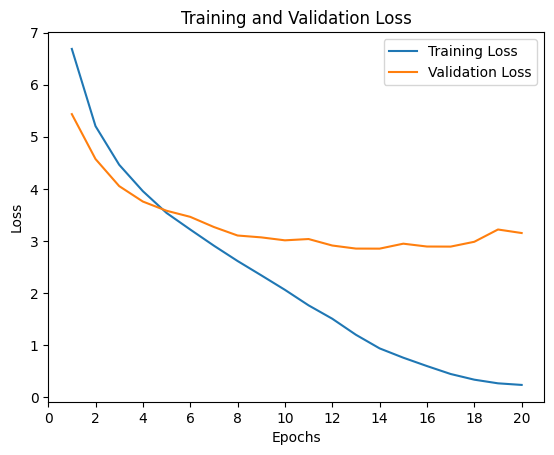

In [135]:
# Load the training and validation loss dictionaries
train_loss = load(open('train_loss.pkl', 'rb'))
val_loss = load(open('val_loss.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 21)


# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')


# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

In [136]:
train_loss

{0: <tf.Tensor: shape=(), dtype=float32, numpy=6.6854577>,
 1: <tf.Tensor: shape=(), dtype=float32, numpy=5.2045183>,
 2: <tf.Tensor: shape=(), dtype=float32, numpy=4.4632397>,
 3: <tf.Tensor: shape=(), dtype=float32, numpy=3.9566977>,
 4: <tf.Tensor: shape=(), dtype=float32, numpy=3.5390325>,
 5: <tf.Tensor: shape=(), dtype=float32, numpy=3.2211778>,
 6: <tf.Tensor: shape=(), dtype=float32, numpy=2.911011>,
 7: <tf.Tensor: shape=(), dtype=float32, numpy=2.6170697>,
 8: <tf.Tensor: shape=(), dtype=float32, numpy=2.3425>,
 9: <tf.Tensor: shape=(), dtype=float32, numpy=2.063792>,
 10: <tf.Tensor: shape=(), dtype=float32, numpy=1.7661085>,
 11: <tf.Tensor: shape=(), dtype=float32, numpy=1.5094538>,
 12: <tf.Tensor: shape=(), dtype=float32, numpy=1.2014846>,
 13: <tf.Tensor: shape=(), dtype=float32, numpy=0.94053984>,
 14: <tf.Tensor: shape=(), dtype=float32, numpy=0.7618492>,
 15: <tf.Tensor: shape=(), dtype=float32, numpy=0.6013766>,
 16: <tf.Tensor: shape=(), dtype=float32, numpy=0.4492

In [137]:
train_values

dict_values([<tf.Tensor: shape=(), dtype=float32, numpy=6.6854577>, <tf.Tensor: shape=(), dtype=float32, numpy=5.2045183>, <tf.Tensor: shape=(), dtype=float32, numpy=4.4632397>, <tf.Tensor: shape=(), dtype=float32, numpy=3.9566977>, <tf.Tensor: shape=(), dtype=float32, numpy=3.5390325>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2211778>, <tf.Tensor: shape=(), dtype=float32, numpy=2.911011>, <tf.Tensor: shape=(), dtype=float32, numpy=2.6170697>, <tf.Tensor: shape=(), dtype=float32, numpy=2.3425>, <tf.Tensor: shape=(), dtype=float32, numpy=2.063792>, <tf.Tensor: shape=(), dtype=float32, numpy=1.7661085>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5094538>, <tf.Tensor: shape=(), dtype=float32, numpy=1.2014846>, <tf.Tensor: shape=(), dtype=float32, numpy=0.94053984>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7618492>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6013766>, <tf.Tensor: shape=(), dtype=float32, numpy=0.44922185>, <tf.Tensor: shape=(), dtype=float32, numpy=0.34024557>,

### Inferencing the transformer model

In [232]:
# Define the model parameters
h = 8 # Number of self-attention heads
d_k = 64 # Dimensionality of the linearly projected queries and keys
d_v = 64 # Dimensionality of the linearly projected values
d_model = 512 # Dimensionality of model layers' outputs
d_ff = 2048 # Dimensionality of the inner fully connected layer
n = 6 # Number of layers in the encoder stack

# Define the dataset parameters
enc_seq_length = 7 # Encoder sequence length
dec_seq_length = 10 # Decoder sequence length
enc_vocab_size = 2195 # Encoder vocabulary size
dec_vocab_size = 3466 # Decoder vocabulary size



In [233]:
# Create model
inferencing_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length,dec_seq_length, h, d_k, d_v, d_model, d_ff, n, 0)

In [234]:
class Translate(Module):
    def __init__(self, inferencing_model, **kwargs):
       super().__init__(**kwargs)
       self.transformer = inferencing_model
    
    def load_tokenizer(self, name):
        with open(name, 'rb') as handle:
            return load(handle)
        
    def __call__(self, sentence):
        # Append start and end of string tokens to the input sentence
        sentence[0] = "<START> " + sentence[0] + " <EOS>"
        
        # Load encoder and decoder tokenizers
        enc_tokenizer = self.load_tokenizer('enc_tokenizer.pkl')
        dec_tokenizer = self.load_tokenizer('dec_tokenizer.pkl')
        
        # Prepare the input sentence by tokenizing, padding and converting to tensor
        encoder_input = enc_tokenizer.texts_to_sequences(sentence)
        encoder_input = pad_sequences(encoder_input,maxlen=enc_seq_length, padding='post')
        encoder_input = convert_to_tensor(encoder_input, dtype=int64)
        
        # Prepare the output <START> token by tokenizing, and converting to tensor
        output_start = dec_tokenizer.texts_to_sequences(["<START>"])
        output_start = convert_to_tensor(output_start[0], dtype=int64)
        
        # Prepare the output <EOS> token by tokenizing, and converting to tensor
        output_end = dec_tokenizer.texts_to_sequences(["<EOS>"])
        output_end = convert_to_tensor(output_end[0], dtype=int64)
        
        # Prepare the output array of dynamic size
        decoder_output = TensorArray(dtype=int64, size=0, dynamic_size=True)
        decoder_output = decoder_output.write(0, output_start)
        
        for i in range(dec_seq_length):
            # Predict an output token
            prediction = self.transformer(encoder_input,transpose(decoder_output.stack()),training=False)
            prediction = prediction[:, -1, :]
            
            # Select the prediction with the highest score
            predicted_id = argmax(prediction, axis=-1)
            predicted_id = predicted_id[0][newaxis]
            
            # Write the selected prediction to the output array at the next
            # available index
            decoder_output = decoder_output.write(i + 1, predicted_id)
            
            # Break if an <EOS> token is predicted
            if predicted_id == output_end:
                break
                
        output = transpose(decoder_output.stack())[0]
        output = output.numpy()
        output_str = []
        
        # Decode the predicted tokens into an output string
        for i in range(output.shape[0]):
            key = output[i]
            output_str.append(dec_tokenizer.index_word[key])
        
        return output_str
        

In [246]:
# Sentence to translate
sentence = ['cat sat on the mat']

In [247]:
# Load the trained model's weights at the specified epoch
inferencing_model.load_weights('weights/wghts18.ckpt')

In [248]:
# Create a new instance of the 'Translate' class
translator = Translate(inferencing_model)

In [249]:
print(translator(sentence))

['start', 'ich', 'bin', 'mir', 'kommen', 'mir', 'ihnen', 'eos']
